In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from chissl.util import chissl_mongo as cm
%load_ext autoreload
%autoreload 2

# Process the 20 Newsgroups Dataset

In [4]:
from sklearn.datasets import fetch_20newsgroups

data = fetch_20newsgroups()

def parse_document(s):
    header, content = s.split('\n\n', 1)
    source, title, _ = header.split('\n', 2)
    return {'source': source.replace('From:', ''),
            'title': title.replace('Subject: ', ''),
            'content': content.strip()}

targets = {
 'comp.os.ms-windows.misc'  : 'Software',
 'comp.windows.x'           : 'Software',
 'comp.sys.ibm.pc.hardware' : 'Hardware',
 'comp.sys.mac.hardware'    : 'Hardware',
 'misc.forsale'             : 'For sale',
 'rec.autos'                : 'Autos',
 'rec.motorcycles'          : 'Autos',
 'rec.sport.baseball'       : 'Sports',
 'rec.sport.hockey'         : 'Sports',
 'sci.med'                  : 'Medicine',
 'sci.space'                : 'Space'
}

df = pd.DataFrame(list(map(parse_document, data.data)))
df['_id'] = np.arange(len(df)).astype('str')
df['group'] = [targets.get(x, 'None') for x in np.array(data.target_names)[data.target]]
df = df[df.group != 'None'].reset_index(drop=True)
df.head()

,content,source,title,_id,group
0,I was wondering if anyone out there could enli...,lerxst@wam.umd.edu (where's my thing),WHAT car is this!?,0,Autos
1,A fair number of brave souls who upgraded thei...,guykuo@carson.u.washington.edu (Guy Kuo),SI Clock Poll - Final Call,1,Hardware
2,"well folks, my mac plus finally gave up the gh...",twillis@ec.ecn.purdue.edu (Thomas E Willis),PB questions...,2,Hardware
3,"From article <C5owCB.n3p@world.std.com>, by to...",jcm@head-cfa.harvard.edu (Jonathan McDowell),Re: Shuttle Launch Question,4,Space
4,There were a few people who responded to my re...,bmdelane@quads.uchicago.edu (brian manning de...,Brain Tumor Treatment (thanks),6,Medicine


# Add text documents to database

In [5]:
cm.ChisslMongo()\
    .create_collection('Newsgroups', df.to_dict(orient='records'), drop=True)

# Create a Newsgroups application

In [6]:
cm.ChisslMongo()\
    .create_application('20 Newsgroups (nmf)',
                        'Newsgroups',
                        'NewsgroupsComponent',
                        'chissl.pipelines.text.TextPipeline',
                         params={'umap__metric': 'cosine'},
                         drop=True)

{'_id': '20 Newsgroups (nmf)',
 'collection': 'Newsgroups',
 'component': 'NewsgroupsComponent',
 'params': {'umap__metric': 'cosine'},
 'pipeline': 'chissl.pipelines.text.TextPipeline',
 'props': {}}

# Fit a model

In [8]:
obj = cm.ChisslMongo(verbose=True)\
    .create_model('20 Newsgroups (nmf)', 'test',
                  project={'group': True},
                  drop=True)

Finding application <20 Newsgroups (nmf)>...OK
Querying collection <Newsgroups> <None>...found 6513...OK
Transforming data...OK
Clustering data...OK
Projecting data for histograms {'group': True}...OK
done.


# Visualize results
We are looking for something with more structure than a big blob if it worked correctly

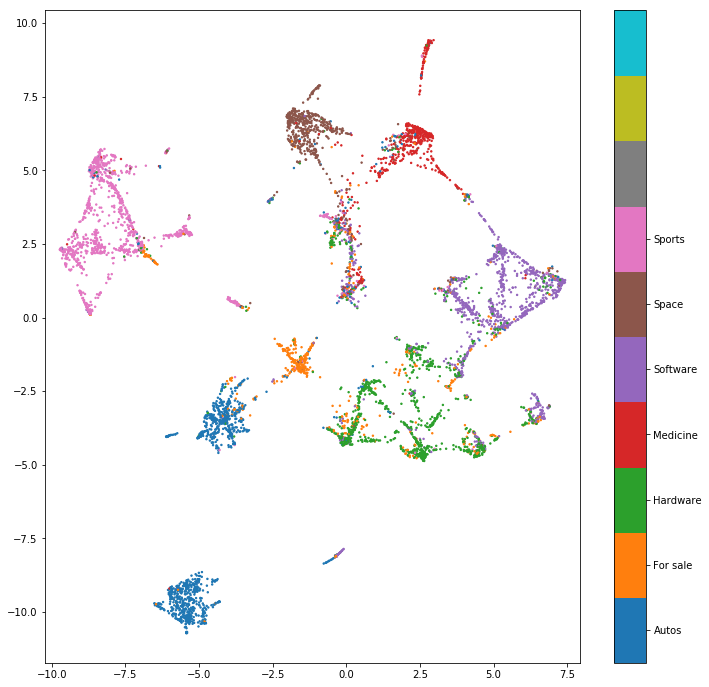

In [9]:
groups = obj['hist']['group']
groups_set = sorted(set(groups))
colors = {v: i for i, v in enumerate(groups_set)}

plt.figure(figsize=(12, 12))
plt.scatter(*np.array(obj['X']).T, s=2, c=list(map(colors.get, groups)), cmap='tab10', vmin=0, vmax=10);
cb = plt.colorbar()
cb.set_ticks(np.arange(len(groups_set)) + .5)
cb.set_ticklabels(groups_set)
plt.axis('equal');

# Deploy the model

In [10]:
labels = df.set_index('_id').iloc[:5000].group.to_dict()

cm.ChisslMongo()\
    .deploy('20 Newsgroups (nmf)', 'test', labels, drop=True);

# Predict on "new" data

In [11]:
cm.ChisslMongo()\
    .get_induction_model('20 Newsgroups (nmf)', 'test')\
    .predict(df.iloc[-30:].to_dict(orient='records'))

array(['Software', 'Medicine', 'Space', 'Software', 'Sports', 'Autos',
       'Software', 'Hardware', 'Sports', 'Space', 'Sports', 'Autos',
       'Hardware', 'Autos', 'Autos', 'Software', 'Sports', 'Hardware',
       'Sports', 'Sports', 'Sports', 'For sale', 'Hardware', 'Hardware',
       'Medicine', 'For sale', 'Medicine', 'Hardware', 'Hardware',
       'Autos'], dtype=object)

In [12]:
cm.ChisslMongo()\
    .get_induction_model('20 Newsgroups (nmf)', 'test')\
    .predict([{'content': 'in want to sell my old honda'}])

array(['For sale'], dtype=object)